# Using xarray to solve Heterogeneous Agent Models


In [1]:
!pip install --quiet estimagic

Import required libraries.


In [2]:
from types import SimpleNamespace

import estimagic as em
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
from HARK.ConsumptionSaving.ConsIndShockModel import PerfForesightConsumerType
from HARK.utilities import (
    CRRAutility,
    CRRAutility_inv,
    CRRAutilityP,
    CRRAutilityP_inv,
    plot_funcs,
)
from xarray import DataArray, Dataset

Basic objects that we'll use to construct the model.


In [3]:
epsilon = 1e-6  # lower bound for cash-on-hand
CRRA = 2.0  # coefficient of relative risk aversion
DiscFac = 0.96  # discounting factor
Rfree = 1.03  # risk free interest rate
params = SimpleNamespace(CRRA=CRRA, DiscFac=DiscFac, Rfree=Rfree)

u = lambda c: CRRAutility(c, CRRA)  # utility
mu = lambda c: CRRAutilityP(c, CRRA)  # marginal utility
u_inv = lambda c: CRRAutility_inv(c, CRRA)  # inverse utility
mu_inv = lambda c: CRRAutilityP_inv(c, CRRA)  # inverse marginal utility

### The Problem


First, we explore the structure of a perfect-foresight consumption-savings model. The agent's problem is to maximize their present DiscFaced utility of consumption subject to a budget constraint. The recursive problem is given by

$$
v_t(m_t) = \max_{c_t} u(c_t) + \beta v_{t+1}(m_{t+1}) \\
s.t. \\
 a_t = m_t - c_t \\
m_{t+1} = R  a_t + 1
$$


This problem can be disected into two stages and two transitions:

First, the agent chooses consumption $c_t$ to maximize their utility given their current cash-on-hand $m_t$ and is left with liquid assets $a_t$.

$$
v_t(m_t) = \max_{c_t} u(c_t) + \beta w_{t}(a_{t}) \\
s.t. \\
 a_t = m_t - c_t \\
$$

Second, the agent receives a constant income and the liquid assets accrue interest, which results in next period's cash-on-hand $m_{t+1}$.

$$
w_t(a_t) = v_{t+1}(m_{t+1}) \\
s.t. \\
 m_{t+1} = R  a_t + 1
$$

Although this is very simple, it will be apparent later why this separation is useful.


### Defining the state space.


We can define the state space two ways: as a numpy grid, or as an xarray.DataArrray.


In [4]:
mVec = np.geomspace(epsilon, 20, 100)  # grid for market resources

The xr.DataArray will be useful for representing the state space in a more general way. We can define the state space as a 1-dimensional array of cash-on-hand values.


In [5]:
mNrm = DataArray(
    mVec,
    name="mNrm",
    dims=("mNrm"),
    attrs={"long_name": "Normalized Market Resources"},
)
state = Dataset({"mNrm": mNrm})  # only one state var in this model

Notice the structure of an xr.DataArray.


In [6]:
state

<xarray.Dataset>
Dimensions:  (mNrm: 100)
Coordinates:
  * mNrm     (mNrm) float64 1e-06 1.185e-06 1.404e-06 ... 14.24 16.88 20.0
Data variables:
    *empty*

We can do the same for the liquid assets, which we can refer to as the post-decision state (post-state for short) of the first stage of the problem, or the state of the second stage of the problem.


In [7]:
aNrm = DataArray(
    mVec,
    name="aNrm",
    dims=("aNrm"),
    attrs={"long_name": "Normalized Liquid Assets"},
)
post_state = Dataset({"aNrm": aNrm})

print(post_state)

<xarray.Dataset>
Dimensions:  (aNrm: 100)
Coordinates:
  * aNrm     (aNrm) float64 1e-06 1.185e-06 1.404e-06 ... 14.24 16.88 20.0
Data variables:
    *empty*


We can now define functions over the state space. In this basic model, we need action/policy/decision of consumption. Starting from the last period, we know that the solution is for the agent to consume all of its resources. Defining it as a function of the state space is easy.


In [8]:
# optimal decision is to consume everything in the last period
cNrm = DataArray(
    mVec,
    name="cNrm",
    dims=state.dims,
    coords=state.coords,
    attrs={"long_name": "Consumption"},
)
actions = Dataset({"cNrm": cNrm})
cNrm

<xarray.DataArray 'cNrm' (mNrm: 100)>
array([1.00000000e-06, 1.18508030e-06, 1.40441531e-06, 1.66434491e-06,
       1.97238237e-06, 2.33743148e-06, 2.77004399e-06, 3.28272456e-06,
       3.89029220e-06, 4.61030863e-06, 5.46358592e-06, 6.47478803e-06,
       7.67314372e-06, 9.09329144e-06, 1.07762805e-05, 1.27707577e-05,
       1.51343734e-05, 1.79354477e-05, 2.12549457e-05, 2.51888173e-05,
       2.98507711e-05, 3.53755607e-05, 4.19228800e-05, 4.96819791e-05,
       5.88771346e-05, 6.97741321e-05, 8.26879492e-05, 9.79918595e-05,
       1.16128222e-04, 1.37621268e-04, 1.63092253e-04, 1.93277416e-04,
       2.29049257e-04, 2.71441762e-04, 3.21680284e-04, 3.81216966e-04,
       4.51772715e-04, 5.35386944e-04, 6.34476519e-04, 7.51905621e-04,
       8.91068537e-04, 1.05598777e-03, 1.25143030e-03, 1.48304539e-03,
       1.75752787e-03, 2.08281165e-03, 2.46829905e-03, 2.92513257e-03,
       3.46651698e-03, 4.10810097e-03, 4.86842952e-03, 5.76947990e-03,
       6.83729695e-03, 8.10274590e-03, 9.60240452e-03, 1.13796204e-02,
       1.34857639e-02, 1.59817131e-02, 1.89396133e-02, 2.24449626e-02,
       2.65990830e-02, 3.15220491e-02, 3.73561594e-02, 4.42700484e-02,
       5.24635622e-02, 6.21735338e-02, 7.36806300e-02, 8.73174629e-02,
       1.03478205e-01, 1.22629982e-01, 1.45326375e-01, 1.72223424e-01,
       2.04098586e-01, 2.41873213e-01, 2.86639180e-01, 3.39690444e-01,
       4.02560453e-01, 4.77066461e-01, 5.65362063e-01, 6.69999442e-01,
       7.94003138e-01, 9.40957475e-01, 1.11511016e+00, 1.32149508e+00,
       1.56607779e+00, 1.85592793e+00, 2.19942362e+00, 2.60649360e+00,
       3.08890421e+00, 3.66059952e+00, 4.33810437e+00, 5.14100201e+00,
       6.09250019e+00, 7.22010194e+00, 8.55640055e+00, 1.01400217e+01,
       1.20167399e+01, 1.42408017e+01, 1.68764936e+01, 2.00000000e+01])
Coordinates:
  * mNrm     (mNrm) float64 1e-06 1.185e-06 1.404e-06 ... 14.24 16.88 20.0
Attributes:
    long_name:  Consumption

### The Value and Marginal Value functions.


To define the value and marginal value functions in the last period, we can use the utility and marginal utility functions.


In [9]:
v = u(cNrm)
v.name = "v"
v.attrs = {"long_name": "Value Function"}

v_der = mu(cNrm)
v_der.name = "v_der"
v_der.attrs = {"long_name": "Marginal Value Function"}

It will also be useful to define the inverse value and inverse marginal value functions.


In [10]:
v_inv = cNrm.copy()
v_inv.name = "v_inv"
v_inv.attrs = {"long_name": "Inverse Value Function"}

v_der_inv = cNrm.copy()
v_der_inv.name = "v_der_inv"
v_der_inv.attrs = {"long_name": "Inverse Marginal Value Function"}

We can now create a xr.Dataset to store all of the variables/functions we have created. Datasets are useful containers of variables that are defined over the same dimensions, or in our case states.


In [11]:
dataset = Dataset(
    {
        "cNrm": cNrm,
        "v": v,
        "v_der": v_der,
        "v_inv": v_inv,
        "v_der_inv": v_der_inv,
    }
)
dataset

<xarray.Dataset>
Dimensions:    (mNrm: 100)
Coordinates:
  * mNrm       (mNrm) float64 1e-06 1.185e-06 1.404e-06 ... 14.24 16.88 20.0
Data variables:
    cNrm       (mNrm) float64 1e-06 1.185e-06 1.404e-06 ... 14.24 16.88 20.0
    v          (mNrm) float64 -1e+06 -8.438e+05 -7.12e+05 ... -0.05925 -0.05
    v_der      (mNrm) float64 1e+12 7.12e+11 5.07e+11 ... 0.003511 0.0025
    v_inv      (mNrm) float64 1e-06 1.185e-06 1.404e-06 ... 14.24 16.88 20.0
    v_der_inv  (mNrm) float64 1e-06 1.185e-06 1.404e-06 ... 14.24 16.88 20.0

We can also create separate datasets for the value function variables and the policy function variable.


In [12]:
value_function = Dataset(
    {"v": v, "v_der": v_der, "v_inv": v_inv, "v_der_inv": v_der_inv}
)
policy_function = Dataset({"cNrm": cNrm})

Up to now I've used the word function for the variables stored as datasets. This is because using the `interp` method we can interpolate the values of the variables at any point in the state space. This is useful for solving the model, as we will see later.


In [13]:
dataset.interp({"mNrm": np.sort(np.random.uniform(epsilon, 20, 10))})

<xarray.Dataset>
Dimensions:    (mNrm: 10)
Coordinates:
  * mNrm       (mNrm) float64 0.09623 1.584 1.954 5.322 ... 13.94 13.95 17.35
Data variables:
    cNrm       (mNrm) float64 0.09623 1.584 1.954 5.322 ... 13.94 13.95 17.35
    v          (mNrm) float64 -10.47 -0.6325 -0.5147 ... -0.07192 -0.05785
    v_der      (mNrm) float64 110.3 0.4006 0.2664 ... 0.005205 0.005192 0.003357
    v_inv      (mNrm) float64 0.09623 1.584 1.954 5.322 ... 13.94 13.95 17.35
    v_der_inv  (mNrm) float64 0.09623 1.584 1.954 5.322 ... 13.94 13.95 17.35

Because of the curvature of the value and marginal value functions, it'll be useful to use the inverse value and marginal value functions instead and re-curve them. For this, I create a new class `ValueFunctionCRRA` that returns the appropriate value and marginal value functions.


In [14]:
class ValueFunctionCRRA(object):
    def __init__(self, dataset: xr.Dataset, CRRA: float):

        self.dataset = dataset
        self.CRRA = CRRA

    def __call__(self, state):
        """
        Interpolate inverse falue function then invert to get value function at given state.
        """

        result = CRRAutility(
            self.dataset["v_inv"].interp(
                state,
                assume_sorted=True,
                kwargs={"fill_value": "extrapolate"},
            ),
            self.CRRA,
        )

        result.name = "v"
        result.attrs = self.dataset["v"].attrs

        return result

    def derivative(self, state):
        """
        Interpolate inverse marginal value function then invert to get marginal value function at given state.
        """
        result = CRRAutilityP(
            self.dataset["v_der_inv"].interp(
                state,
                assume_sorted=True,
                kwargs={"fill_value": "extrapolate"},
            ),
            self.CRRA,
        )

        result.name = "v_der"
        result.attrs = self.dataset["v"].attrs

        return result

    def evaluate(self, state):
        """
        Interpolate all data variables in the dataset.
        """

        result = self.dataset.interp(state, kwargs={"fill_value": "extrapolate"})
        result.attrs = self.dataset["v"].attrs

        return result

In [15]:
vfunc = ValueFunctionCRRA(value_function, CRRA)

In [16]:
rand_states = np.sort(np.random.uniform(mVec[1], mVec[-1], 100))
rand_states

array([ 0.75674348,  0.77176043,  0.80768986,  0.96341314,  1.09167281,
        1.16930423,  1.22388102,  1.23034933,  1.36923507,  1.38789361,
        1.41775481,  1.4593857 ,  1.59732059,  1.73191157,  2.23779684,
        2.38009568,  2.41243217,  2.61947805,  2.90440835,  3.02503064,
        3.05402291,  3.58232867,  4.12522588,  4.34123513,  4.60400331,
        4.65903677,  4.83231929,  4.87690888,  4.97520435,  4.97715528,
        5.14387343,  5.20888227,  5.4370924 ,  5.94942429,  6.7487039 ,
        6.88597787,  7.00363861,  7.00625993,  7.01158013,  7.26795723,
        7.47484815,  7.4895535 ,  7.96451979,  8.06859562,  8.11778852,
        8.15539541,  8.55668918,  8.73422048,  8.86458979,  9.17157804,
        9.25182462,  9.29792839,  9.63209717,  9.72210314,  9.77486699,
        9.90137887,  9.91215073,  9.94172007,  9.97094401, 10.16617291,
       10.51524929, 10.56043414, 10.75490037, 10.99984325, 11.08407153,
       11.10637006, 11.10725338, 11.15107033, 11.97339613, 12.66

In [17]:
rand_ds = vfunc.evaluate({"mNrm": rand_states})
rand_ds

<xarray.Dataset>
Dimensions:    (mNrm: 100)
Coordinates:
  * mNrm       (mNrm) float64 0.7567 0.7718 0.8077 0.9634 ... 19.24 19.47 19.67
Data variables:
    v          (mNrm) float64 -1.329 -1.301 -1.241 ... -0.05158 -0.05097
    v_der      (mNrm) float64 1.779 1.701 1.544 ... 0.002746 0.002673 0.002606
    v_inv      (mNrm) float64 0.7567 0.7718 0.8077 0.9634 ... 19.24 19.47 19.67
    v_der_inv  (mNrm) float64 0.7567 0.7718 0.8077 0.9634 ... 19.24 19.47 19.67
Attributes:
    long_name:  Value Function

In [18]:
rand_v = vfunc({"mNrm": rand_states})
np.max(np.abs(rand_v - rand_ds["v"]))

<xarray.DataArray 'v' ()>
array(0.00802848)

### State transitions


In [19]:
def state_transition(s=None, a=None, params=None):
    """
    state to post_state transition
    """
    ps = {}  # pytree
    ps["aNrm"] = s["mNrm"] - a["cNrm"]
    return ps


def post_state_transition(ps=None, params=None):
    """
    post_state to next_state transition
    """
    ns = {}  # pytree
    ns["mNrm"] = params.Rfree * ps["aNrm"] + 1
    return ns

In [20]:
ps = Dataset(state_transition(state, policy_function, params))
ps

<xarray.Dataset>
Dimensions:  (mNrm: 100)
Coordinates:
  * mNrm     (mNrm) float64 1e-06 1.185e-06 1.404e-06 ... 14.24 16.88 20.0
Data variables:
    aNrm     (mNrm) float64 0.0 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0 0.0

In [21]:
ns = Dataset(post_state_transition(ps, params))
ns

<xarray.Dataset>
Dimensions:  (mNrm: 100)
Coordinates:
  * mNrm     (mNrm) float64 1.0 1.0 1.0 1.0 1.0 1.0 ... 1.0 1.0 1.0 1.0 1.0 1.0
Data variables:
    *empty*

In [22]:
ns = Dataset(post_state_transition(state_transition(state, dataset, params), params))
ns

<xarray.Dataset>
Dimensions:  (mNrm: 100)
Coordinates:
  * mNrm     (mNrm) float64 1.0 1.0 1.0 1.0 1.0 1.0 ... 1.0 1.0 1.0 1.0 1.0 1.0
Data variables:
    *empty*

In [23]:
def value_transition(a=None, s=None, continuation=None, params=None):
    """
    value of action given state and continuation
    """
    variables = {}  # pytree
    ps = state_transition(s, a, params)
    variables.update(ps)

    variables["reward"] = u(a["cNrm"])
    variables["v"] = variables["reward"] + params.DiscFac * continuation(ps)
    variables["v_inv"] = u_inv(variables["v"])

    variables["marginal_reward"] = mu(a["cNrm"])
    variables["v_der"] = variables["marginal_reward"]  # envelope condition
    variables["v_der_inv"] = mu_inv(variables["v_der"])

    # for estimagic purposes
    variables["contributions"] = variables["v_inv"]
    variables["value"] = np.sum(variables["v_inv"])

    return variables


def continuation_transition(ps=None, value_next=None, params=None):
    """
    continuation value function of post_states
    """
    variables = {}  # pytree
    ns = post_state_transition(ps, params)
    variables.update(ns)

    variables["v"] = value_next(ns)
    variables["v_inv"] = u_inv(variables["v"])

    variables["v_der"] = params.Rfree * value_next.derivative(ns)
    variables["v_der_inv"] = mu_inv(variables["v_der"])

    # for estimagic purposes
    variables["contributions"] = variables["v_inv"]
    variables["value"] = np.sum(variables["v_inv"])

    return variables

In [24]:
v_end = Dataset(continuation_transition(post_state, vfunc, params))
v_end = v_end.drop(["mNrm"])

In [25]:
wfunc = ValueFunctionCRRA(v_end, CRRA)

In [26]:
Dataset(value_transition(policy_function, state, wfunc, params))

<xarray.Dataset>
Dimensions:          (mNrm: 100)
Coordinates:
  * mNrm             (mNrm) float64 1e-06 1.185e-06 1.404e-06 ... 16.88 20.0
    aNrm             (mNrm) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
Data variables:
    reward           (mNrm) float64 -1e+06 -8.438e+05 ... -0.05925 -0.05
    v                (mNrm) float64 -1e+06 -8.438e+05 -7.12e+05 ... -1.019 -1.01
    v_inv            (mNrm) float64 1e-06 1.185e-06 1.404e-06 ... 0.9811 0.9901
    marginal_reward  (mNrm) float64 1e+12 7.12e+11 5.07e+11 ... 0.003511 0.0025
    v_der            (mNrm) float64 1e+12 7.12e+11 5.07e+11 ... 0.003511 0.0025
    v_der_inv        (mNrm) float64 1e-06 1.185e-06 1.404e-06 ... 16.88 20.0
    contributions    (mNrm) float64 1e-06 1.185e-06 1.404e-06 ... 0.9811 0.9901
    value            float64 18.93

In [27]:
res = em.maximize(
    value_transition,
    params={"cNrm": mVec / 2},
    algorithm="scipy_lbfgsb",
    criterion_kwargs={"s": state, "continuation": wfunc, "params": params},
    lower_bounds={"cNrm": np.zeros_like(mVec)},
    upper_bounds={"cNrm": state["mNrm"].data},
)

optimal_actions = Dataset(data_vars=res.params, coords={"mNrm": mVec})
optimal_actions

<xarray.Dataset>
Dimensions:  (cNrm: 100, mNrm: 100)
Coordinates:
  * cNrm     (cNrm) float64 1e-06 1.185e-06 1.404e-06 ... 7.74 9.081 10.67
  * mNrm     (mNrm) float64 1e-06 1.185e-06 1.404e-06 ... 14.24 16.88 20.0
Data variables:
    *empty*

In [28]:
c_opt = DataArray(
    res.params["cNrm"],
    name="cNrm",
    dims=state.dims,
    coords=state.coords,
    attrs={"long_name": "consumption"},
)
optimal_actions = Dataset({"cNrm": c_opt})
optimal_actions

<xarray.Dataset>
Dimensions:  (mNrm: 100)
Coordinates:
  * mNrm     (mNrm) float64 1e-06 1.185e-06 1.404e-06 ... 14.24 16.88 20.0
Data variables:
    cNrm     (mNrm) float64 1e-06 1.185e-06 1.404e-06 ... 7.74 9.081 10.67

In [29]:
grid_search = Dataset(value_transition(optimal_actions, state, wfunc, params))
grid_search = xr.merge([grid_search, state, optimal_actions])
grid_search

<xarray.Dataset>
Dimensions:          (mNrm: 100)
Coordinates:
  * mNrm             (mNrm) float64 1e-06 1.185e-06 1.404e-06 ... 16.88 20.0
    aNrm             (mNrm) float64 0.0 0.0 0.0 0.0 ... 5.409 6.501 7.795 9.33
Data variables:
    reward           (mNrm) float64 -1e+06 -8.438e+05 ... -0.1101 -0.09372
    v                (mNrm) float64 -1e+06 -8.438e+05 ... -0.2164 -0.1842
    v_inv            (mNrm) float64 1e-06 1.185e-06 1.404e-06 ... 4.62 5.429
    marginal_reward  (mNrm) float64 1e+12 7.12e+11 5.07e+11 ... 0.01213 0.008784
    v_der            (mNrm) float64 1e+12 7.12e+11 5.07e+11 ... 0.01213 0.008784
    v_der_inv        (mNrm) float64 1e-06 1.185e-06 1.404e-06 ... 9.081 10.67
    contributions    (mNrm) float64 1e-06 1.185e-06 1.404e-06 ... 4.62 5.429
    value            float64 40.31
    cNrm             (mNrm) float64 1e-06 1.185e-06 1.404e-06 ... 9.081 10.67

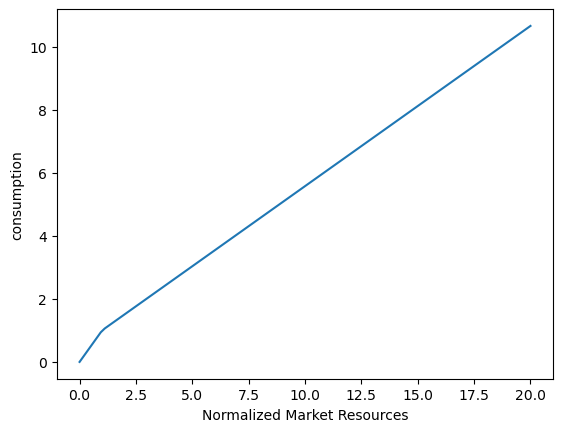

In [30]:
grid_search["cNrm"].plot()

In [31]:
hark_agent = PerfForesightConsumerType(
    CRRA=params.CRRA,
    DiscFac=params.DiscFac,
    Rfree=params.Rfree,
    LivPrb=[1.0],
    PermGroFac=[1.0],
    BoroCnstArt=0.0,
)
hark_agent.solve()

In [32]:
np.max(np.abs(hark_agent.solution[0].cFunc(mVec) - grid_search["cNrm"]))

<xarray.DataArray 'cNrm' ()>
array(0.00036489)

In [33]:
def reverse_transition(ps=None, a=None, params=None):

    states = {}  # pytree
    states["mNrm"] = ps["aNrm"] + a["cNrm"]

    return states


def egm_transition(ps=None, continuation=None, params=None):
    """actions from post_states"""

    actions = {}  # pytree
    actions["cNrm"] = mu_inv(params.DiscFac * continuation.derivative(ps))

    return actions

In [34]:
acted = egm_transition(post_state, wfunc, params)
states = reverse_transition(post_state, acted, params)

actions = Dataset(acted).swap_dims({"aNrm": "mNrm"})  # egm requires swap dimensions
states = Dataset(states).swap_dims({"aNrm": "mNrm"})

egm_dataset = xr.merge([actions, states])

values = value_transition(actions, states, wfunc, params)
egm_dataset.update(values)

<xarray.Dataset>
Dimensions:          (mNrm: 100)
Coordinates:
  * mNrm             (mNrm) float64 1.006 1.006 1.006 1.006 ... 30.0 35.36 41.72
    aNrm             (mNrm) float64 1e-06 1.185e-06 1.404e-06 ... 16.88 20.0
Data variables:
    cNrm             (mNrm) float64 1.006 1.006 1.006 ... 15.76 18.49 21.72
    reward           (mNrm) float64 -0.9944 -0.9944 ... -0.05409 -0.04604
    v                (mNrm) float64 -1.954 -1.954 -1.954 ... -0.1063 -0.09048
    v_inv            (mNrm) float64 0.5117 0.5117 0.5117 ... 8.017 9.406 11.05
    marginal_reward  (mNrm) float64 0.9888 0.9888 0.9888 ... 0.002926 0.002119
    v_der            (mNrm) float64 0.9888 0.9888 0.9888 ... 0.002926 0.002119
    v_der_inv        (mNrm) float64 1.006 1.006 1.006 ... 15.76 18.49 21.72
    contributions    (mNrm) float64 0.5117 0.5117 0.5117 ... 8.017 9.406 11.05
    value            float64 118.7

In [35]:
borocnst = Dataset(
    coords={
        "mNrm": 0.0,
        "aNrm": 0.0,
    },
    data_vars={
        "cNrm": 0.0,
        "v": -np.inf,
        "v_inv": 0.0,
        "reward": -np.inf,
        "marginal_reward": np.inf,
        "v_der": np.inf,
        "v_der_inv": 0.0,
    },
)
borocnst

<xarray.Dataset>
Dimensions:          ()
Coordinates:
    mNrm             float64 0.0
    aNrm             float64 0.0
Data variables:
    cNrm             float64 0.0
    v                float64 -inf
    v_inv            float64 0.0
    reward           float64 -inf
    marginal_reward  float64 inf
    v_der            float64 inf
    v_der_inv        float64 0.0

In [36]:
egm = xr.concat([borocnst, egm_dataset], dim="mNrm", combine_attrs="no_conflicts")
egm

<xarray.Dataset>
Dimensions:          (mNrm: 101)
Coordinates:
  * mNrm             (mNrm) float64 0.0 1.006 1.006 1.006 ... 30.0 35.36 41.72
    aNrm             (mNrm) float64 0.0 1e-06 1.185e-06 ... 14.24 16.88 20.0
Data variables:
    value            float64 118.7
    cNrm             (mNrm) float64 0.0 1.006 1.006 1.006 ... 15.76 18.49 21.72
    v                (mNrm) float64 -inf -1.954 -1.954 ... -0.1063 -0.09048
    v_inv            (mNrm) float64 0.0 0.5117 0.5117 ... 8.017 9.406 11.05
    reward           (mNrm) float64 -inf -0.9944 -0.9944 ... -0.05409 -0.04604
    marginal_reward  (mNrm) float64 inf 0.9888 0.9888 ... 0.002926 0.002119
    v_der            (mNrm) float64 inf 0.9888 0.9888 ... 0.002926 0.002119
    v_der_inv        (mNrm) float64 0.0 1.006 1.006 1.006 ... 15.76 18.49 21.72

In [37]:
np.max(np.abs(egm["cNrm"].interp({"mNrm": mVec}) - hark_agent.solution[0].cFunc(mVec)))

<xarray.DataArray 'cNrm' ()>
array(9.35671381e-07)

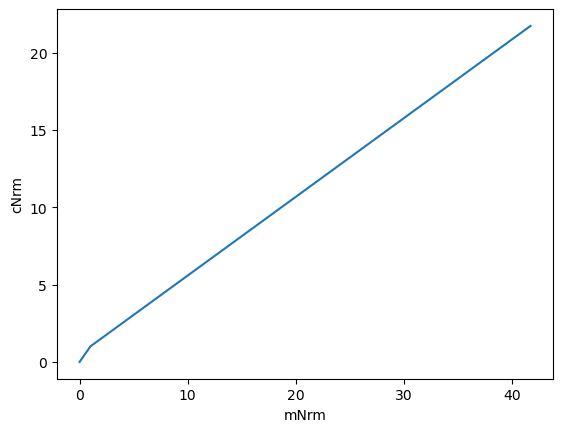

In [38]:
egm["cNrm"].plot()

In [39]:
from HARK.ConsumptionSaving.ConsLabeledModel import (
    PerfForesightLabeledType,
)

agent = PerfForesightLabeledType(cycles=0, BoroCnstArt=-1.0)
agent.solve()

GPFRaw                 = 0.984539 
GPFNrm                 = 0.993777 
GPFAggLivPrb           = 0.964848 
Thorn = APF            = 0.994384 
PermGroFacAdj          = 1.000611 
uInvEpShkuInv          = 0.990704 
VAF                    = 0.932054 
WRPF                   = 0.213705 
DiscFacGPFNrmMax       = 0.972061 
DiscFacGPFAggLivPrbMax = 1.010600 


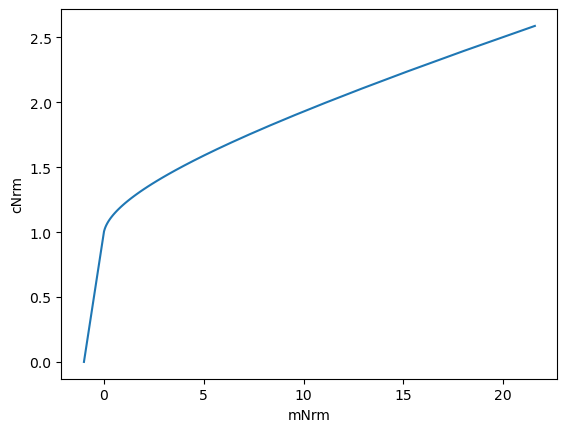

In [40]:
agent.solution[0].policy["cNrm"].plot()

In [41]:
hark_agent = PerfForesightConsumerType(cycles=0, BoroCnstArt=-1.0)
hark_agent.solve()

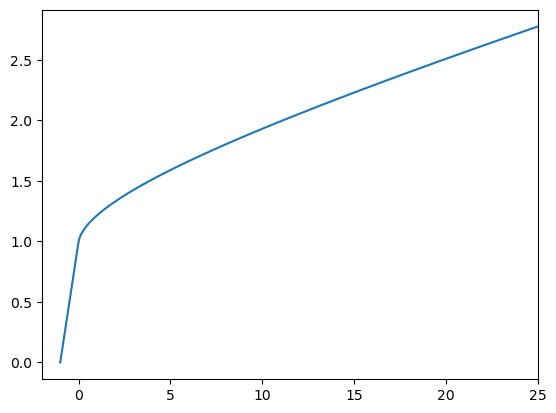

In [42]:
plot_funcs(hark_agent.solution[0].cFunc, hark_agent.solution[0].mNrmMin - 1, 25)

In [43]:
np.max(
    np.abs(
        hark_agent.solution[0].cFunc(mVec)
        - agent.solution[0].policy["cNrm"].interp({"mNrm": mVec})
    )
)

<xarray.DataArray 'cNrm' ()>
array(0.00671175)

In [44]:
agent.completed_cycles

304

In [45]:
hark_agent.completed_cycles

407

In [46]:
agent.solution[0].value.dataset

<xarray.Dataset>
Dimensions:    (mNrm: 50)
Coordinates:
  * mNrm       (mNrm) float64 -1.0 0.005699 0.007745 ... 15.2 18.03 21.59
Data variables:
    v          (mNrm) float64 -inf -22.45 -22.43 -21.99 ... -10.09 -9.425 -8.724
    v_der      (mNrm) float64 inf 0.9887 0.9866 0.9485 ... 0.1996 0.1742 0.1492
    v_inv      (mNrm) float64 0.0 0.04453 0.04458 ... 0.0991 0.1061 0.1146
    v_der_inv  (mNrm) float64 0.0 1.006 1.007 1.027 ... 2.107 2.238 2.396 2.589

In [47]:
from HARK.ConsumptionSaving.ConsLabeledModel import IndShockLabeledType

agent = IndShockLabeledType(cycles=0)
agent.solve()

GPFRaw                 = 0.984539 
GPFNrm                 = 0.993777 
GPFAggLivPrb           = 0.964848 
Thorn = APF            = 0.994384 
PermGroFacAdj          = 1.000611 
uInvEpShkuInv          = 0.990704 
VAF                    = 0.932054 
WRPF                   = 0.213705 
DiscFacGPFNrmMax       = 0.972061 
DiscFacGPFAggLivPrbMax = 1.010600 


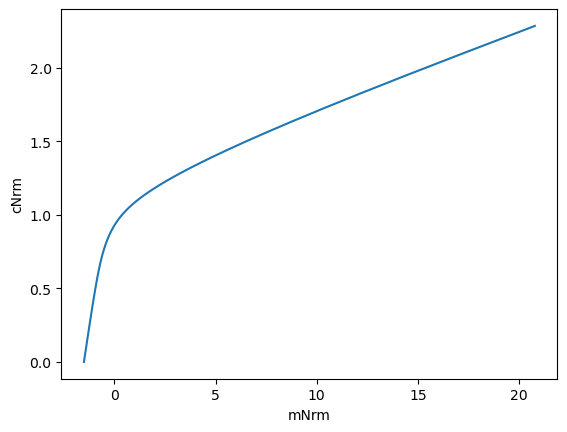

In [48]:
agent.solution[0].policy["cNrm"].plot()

In [49]:
from HARK.ConsumptionSaving.ConsIndShockModel import IndShockConsumerType

hark_agent = IndShockConsumerType(cycles=0, BoroCnstArt=None)
hark_agent.solve()

GPFRaw                 = 0.984539 
GPFNrm                 = 0.993777 
GPFAggLivPrb           = 0.964848 
Thorn = APF            = 0.994384 
PermGroFacAdj          = 1.000611 
uInvEpShkuInv          = 0.990704 
VAF                    = 0.932054 
WRPF                   = 0.213705 
DiscFacGPFNrmMax       = 0.972061 
DiscFacGPFAggLivPrbMax = 1.010600 


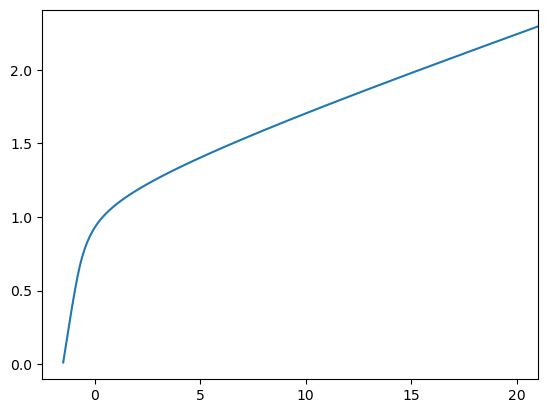

In [50]:
plot_funcs(hark_agent.solution[0].cFunc, hark_agent.solution[0].mNrmMin - 1, 21)

In [51]:
mgrid = np.linspace(hark_agent.solution[0].mNrmMin, 20)
np.max(
    np.abs(
        hark_agent.solution[0].cFunc(mgrid)
        - agent.solution[0].policy["cNrm"].interp({"mNrm": mgrid})
    ),
)

<xarray.DataArray 'cNrm' ()>
array(0.00023666)

In [52]:
from HARK.ConsumptionSaving.ConsLabeledModel import RiskyAssetLabeledType

agent = RiskyAssetLabeledType(cycles=0)
agent.solve()

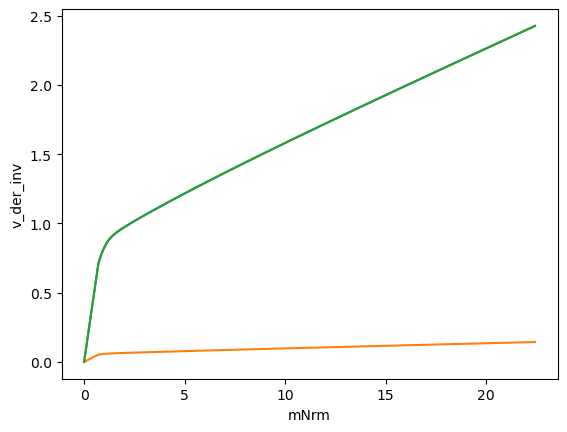

In [53]:
agent.solution[0].policy["cNrm"].plot()
agent.solution[0].value.dataset["v_inv"].plot()
agent.solution[0].value.dataset["v_der_inv"].plot()